# HumanActivity, PCA
---
- HumanActivity 데이터를 읽어서, 컬럼을 300개로 축소(PCA) 시켜서,
RandomForest 모델로 분류하세용
- GridSearchCV 로 베스트 모델 찾기
- 최종 결과
    - 테스트 데이터의 정확도
    - Confusion Matrix 표시

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import myutils as my

### 데이터 준비하기

In [32]:
human = pd.read_csv('train.csv')
human.shape

(7352, 563)

In [33]:
human.keys()

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

In [34]:
human['Activity'].value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [35]:
df = human.copy()


### 데이터 인코딩

In [36]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Activity'] = encoder.fit_transform(df['Activity'])

In [37]:
X = df.drop('Activity', axis = 1)
y = df['Activity']

### 테스트 셋 분리

In [38]:
# 테스트 셋 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                    stratify=y, # y에 0,1,2 예쁘게 집어넣는거? 인터넷 설명한번 보기
                                                   random_state=2022)
print(X_train.shape,X_test.shape)

(5881, 562) (1471, 562)


In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_train[:5]

array([[ 0.78927801, -0.12948955, -0.32231415, ..., -1.06351811,
        -2.31421026, -0.37619172],
       [-0.67923924, -1.76230339, -4.53673189, ...,  0.64593933,
         0.54964062, -1.15559206],
       [ 0.08249411, -0.0412668 ,  0.05871151, ..., -0.27163988,
        -0.71127157, -1.82364949],
       [-0.38771899,  0.1674937 , -0.1149995 , ...,  0.24962948,
        -0.14374468,  0.95992314],
       [-0.50537622,  0.2077963 ,  0.23248231, ...,  0.59340697,
        -0.16188406, -0.71022044]])

### 차원 축소

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
X_train = pca.fit_transform(X_train)
X_train[:5]

array([[-1.25107097e+01, -6.63737443e+00,  8.07874828e+00, ...,
        -4.87441442e-02, -5.74450846e-02,  1.43949786e-01],
       [ 1.15320598e+01, -7.96774990e+00, -4.53762808e-01, ...,
         2.90828004e-02,  4.88489878e-03, -1.15517202e-01],
       [-1.55111849e+01,  6.03696737e-01,  4.20751916e+00, ...,
        -6.63570708e-02,  8.05131017e-02, -1.20301706e-01],
       [ 2.19363700e+01,  2.12551997e+00, -3.32720737e+00, ...,
         8.69696476e-02, -1.82186960e-01,  5.06289999e-02],
       [ 5.38307286e+00, -4.32753278e+00, -3.55165304e+00, ...,
        -4.43994536e-02,  4.68448581e-02, -1.32310616e-01]])

In [41]:
type(X_train), type(y_train)

(numpy.ndarray, pandas.core.series.Series)

In [42]:
y_train.values

array([0, 5, 1, ..., 4, 0, 2])

### GridSearch (그리드 서치 다시 해보기, 수정씨거 돌려보면서)

In [43]:
params = {
        'max_depth' :[5, 10, 15],
        'n_estimators' : [50, 100, 150, 200]
    }
params

{'max_depth': [5, 10, 15], 'n_estimators': [50, 100, 150, 200]}

In [44]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [45]:
clf = RandomForestClassifier(n_estimators = 30)
gs = GridSearchCV(estimator = clf, #여러개 생성
                 scoring = 'accuracy',
                 param_grid = params, #파라미터를 기준으로 하나씩 집어넣음
                 cv = 5, #테스트 셋을 여러개로 나눔
                 n_jobs = -1, #학습 쓰레드
                  verbose=3 #알려주는거
                 )
gs.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=30), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy', verbose=3)

In [46]:
gs.best_estimator_

RandomForestClassifier(max_depth=15, n_estimators=200)

In [47]:
gs.best_score_

0.9267131066530265

In [48]:
gs.best_params_

{'max_depth': 15, 'n_estimators': 200}

### 재학습

In [49]:
clf = RandomForestClassifier(max_depth=15, n_estimators=200)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=200)

In [50]:
clf.score(X_train, y_train)

1.0

In [51]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
X_test = pca.fit_transform(X_test)

In [52]:
clf.score(X_test, y_test)

0.13052345343303876

In [53]:
clf.feature_importances_

array([0.09979909, 0.03727704, 0.04637132, 0.076868  , 0.07287685,
       0.01890947, 0.01149083, 0.02496023, 0.00831441, 0.01011217,
       0.0110953 , 0.00798038, 0.01003935, 0.0061222 , 0.00471229,
       0.00438535, 0.00871204, 0.00278776, 0.00347139, 0.0019653 ,
       0.00207203, 0.00478102, 0.00295824, 0.00502969, 0.00541504,
       0.00503318, 0.00215157, 0.00330665, 0.00570217, 0.00308942,
       0.00533369, 0.00210292, 0.00240156, 0.00457135, 0.00197947,
       0.00170145, 0.00415075, 0.00483526, 0.00322564, 0.00254451,
       0.00180017, 0.0028727 , 0.00232994, 0.00190346, 0.00224462,
       0.00275197, 0.00224098, 0.00179342, 0.00189604, 0.00196119,
       0.00321178, 0.0020401 , 0.00149601, 0.00188455, 0.00230075,
       0.0019315 , 0.00177214, 0.00177813, 0.00226554, 0.00168161,
       0.00162603, 0.00226354, 0.00136815, 0.00177183, 0.00154962,
       0.00124198, 0.00142127, 0.00150631, 0.00169523, 0.00143314,
       0.00139098, 0.00157401, 0.00141346, 0.00152876, 0.00149

In [60]:
sr = pd.Series(clf.feature_importances_)
sr = sr.sort_values(ascending=False)

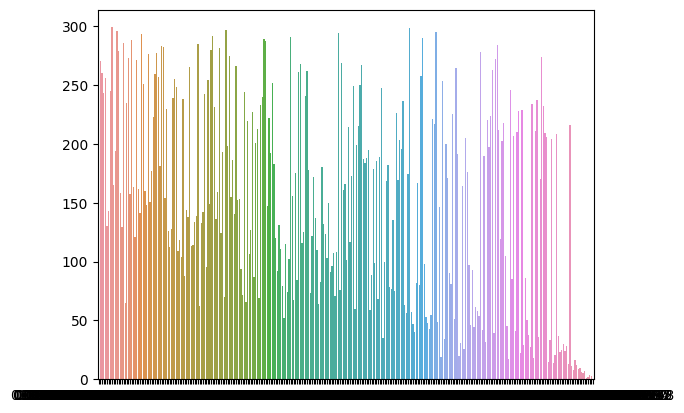

In [61]:
sns.barplot(x=sr, y=sr.index)
plt.show()